In [ ]:
# This all runs, but the almost last cell, somethng within the beam search method
# takes 4ever to run ... 

In [1]:
import time
from datetime import date

startTime = time.time()
todaysDate = date.today()

# LSTMs for Text Generation

<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/packt_nlp_tensorflow_2/blob/master/Ch08-Language-Modelling-with-LSTMs/ch08_lstms_for_text_generation.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>


In [2]:
import os
from six.moves.urllib.request import urlretrieve
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

2023-01-19 21:46:53.269860: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 21:46:53.895472: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 21:46:53.895563: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 21:46:53.895570: W tensorfl

## Downloading Stories
Stories are automatically downloaded from https://www.cs.cmu.edu/~spok/grimmtmp/, if not detected in the disk. The total size of stories is around ~500KB. The dataset consists of 209 stories.

In [3]:
url = 'https://www.cs.cmu.edu/~spok/grimmtmp/'
# dir_name = 'data'
dir_name = 'grimmtmp'

def download_data(url, filename, download_dir):
    """Download a file if not present, and make sure it's the right size."""
      
    # Create directories if doesn't exist
    os.makedirs(download_dir, exist_ok=True)
    
    # If file doesn't exist download
    if not os.path.exists(os.path.join(download_dir,filename)):
        filepath, _ = urlretrieve(url + filename, os.path.join(download_dir,filename))
    else:
        filepath = os.path.join(download_dir, filename)
        
    return filepath

# Number of files and their names to download
num_files = 209
filenames = [format(i, '03d')+'.txt' for i in range(1,num_files+1)]

# Download each file
for fn in filenames:
    download_data(url, fn, dir_name)
    
# Check if all files are downloaded
for i in range(len(filenames)):
    file_exists = os.path.isfile(os.path.join(dir_name,filenames[i]))
    assert file_exists
print(f"{len(filenames)} files found.") 

209 files found.


## Split train, validation and test data

In [4]:
from sklearn.model_selection import train_test_split

# Fix the random seed so we get the same outptu everytime
random_state = 54321

filenames = [os.path.join(dir_name, f) for f in os.listdir(dir_name)]

# First separate train and valid+test data
train_filenames, test_and_valid_filenames = train_test_split(filenames, test_size=0.2, random_state=random_state)

# Separate valid+test data to validation and test data
valid_filenames, test_filenames = train_test_split(test_and_valid_filenames, test_size=0.5, random_state=random_state) 

# Print out the sizes and some sample filenames
for subset_id, subset in zip(('train', 'valid', 'test'), (train_filenames, valid_filenames, test_filenames)):
    print(f"Got {len(subset)} files in the {subset_id} dataset (e.g. {subset[:3]})")

Got 167 files in the train dataset (e.g. ['grimmtmp/086.txt', 'grimmtmp/102.txt', 'grimmtmp/177.txt'])
Got 21 files in the valid dataset (e.g. ['grimmtmp/096.txt', 'grimmtmp/047.txt', 'grimmtmp/025.txt'])
Got 21 files in the test dataset (e.g. ['grimmtmp/048.txt', 'grimmtmp/207.txt', 'grimmtmp/067.txt'])


## Find the vocabulary size

In [5]:
bigram_set = set()

# Go through each file in the training set
for fname in train_filenames:
    document = [] # This will hold all the text
    with open(fname, 'r') as f:
        for row in f:
            # Convert text to lower case to reduce input dimensionality
            document.append(row.lower())
            
        # From the list of text we have, generate one long string (containing all training stories)
        document = " ".join(document)
        
        # Update the set with all bigrams found
        bigram_set.update([document[i:i+2] for i in range(0, len(document), 2)])

# Assign to a variable and print 
n_vocab = len(bigram_set)
print(f"Found {n_vocab} unique bigrams")

Found 693 unique bigrams


## Reading data and generate batches for the model (`tf.data` API)

Here we are going to define a somewhat complex `tf.data` pipeline that would do all the required transformations for us.

---
*Process for generating data to train the language model*

![Generating data for the language model](notebook_images/08_01.png)

In [6]:
def generate_tf_dataset(filenames, ngram_width, window_size, batch_size, shuffle=False):
    """ Generate batched data from a list of files speficied """
    
    # Read the data found in the documents
    documents = []
    for f in filenames:
        doc = tf.io.read_file(f)
        doc = tf.strings.ngrams(    # Generate ngrams from the string
            tf.strings.bytes_split(    # Create a list of chars from a string
                tf.strings.regex_replace(    # Replace new lines with space
                    tf.strings.lower(    # Convert string to lower case
                        doc
                    ), "\n", " "
                )
            ),
            ngram_width, separator=''
        )
        documents.append(doc.numpy().tolist())
    
    # documents is a list of list of strings, where each string is a story
    # From that we generate a ragged tensor
    documents = tf.ragged.constant(documents)
    # Create a dataset where each row in the ragged tensor would be a sample
    doc_dataset = tf.data.Dataset.from_tensor_slices(documents)
    # We need to perform a quick transformation - tf.strings.ngrams would generate
    # all the ngrams (e.g. abcd -> ab, bc, cd) with overlap, however for our data
    # we do not need the overlap, so we need to skip the overlapping ngrams
    # the following line does that
    doc_dataset = doc_dataset.map(lambda x: x[::ngram_width])
    
    # Here we are using a window function to generate windows from text
    # For a text sequence with window_size 3 and shift 1 you get
    # e.g. ab, cd, ef, gh, ij, ... -> [ab, cd, ef], [cd, ef, gh], [ef, gh, ij], ...
    # each of these windows is a single training sequence for our model
    doc_dataset = doc_dataset.flat_map(
        lambda x: tf.data.Dataset.from_tensor_slices(
            x
        ).window(
            size=window_size+1, shift=int(window_size * 0.75)
        ).flat_map(
            lambda window: window.batch(window_size+1, drop_remainder=True)
        )
    )
    
    # From each windowed sequence we generate input and target tuple
    # e.g. [ab, cd, ef] -> ([ab, cd], [cd, ef])
    doc_dataset = doc_dataset.map(lambda x: (x[:-1], x[1:]))
    
    # Shuffle the data if required
    doc_dataset = doc_dataset.shuffle(buffer_size=batch_size*10) if shuffle else doc_dataset
    
    # Batch the data
    doc_dataset = doc_dataset.batch(batch_size=batch_size)
    
    # Return the data
    return doc_dataset


ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)
test_ds = generate_tf_dataset(test_filenames, ngram_length, window_size, batch_size)

2023-01-19 21:46:54.963819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 21:46:54.964198: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 21:46:54.964391: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 21:46:54.964534: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least on

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## Generate few samples from the dataset function

In [7]:
ds = generate_tf_dataset(train_filenames, 2, window_size=10, batch_size=1).take(5)

for record in ds:
    print(record[0].numpy(), '->', record[1].numpy())

[[b'th' b'er' b'e ' b'wa' b's ' b'on' b'ce' b' u' b'po' b'n ']] -> [[b'er' b'e ' b'wa' b's ' b'on' b'ce' b' u' b'po' b'n ' b'a ']]
[[b' u' b'po' b'n ' b'a ' b'ti' b'me' b' a' b' k' b'in' b'g ']] -> [[b'po' b'n ' b'a ' b'ti' b'me' b' a' b' k' b'in' b'g ' b'wh']]
[[b' k' b'in' b'g ' b'wh' b'o ' b'ha' b'd ' b'a ' b'li' b'tt']] -> [[b'in' b'g ' b'wh' b'o ' b'ha' b'd ' b'a ' b'li' b'tt' b'le']]
[[b'a ' b'li' b'tt' b'le' b' b' b'oy' b' i' b'n ' b'wh' b'os']] -> [[b'li' b'tt' b'le' b' b' b'oy' b' i' b'n ' b'wh' b'os' b'e ']]
[[b'n ' b'wh' b'os' b'e ' b'st' b'ar' b's ' b'it' b' h' b'ad']] -> [[b'wh' b'os' b'e ' b'st' b'ar' b's ' b'it' b' h' b'ad' b' b']]


## Defining the model

In [8]:
import tensorflow.keras.backend as K

K.clear_session()
tf.compat.v1.reset_default_graph()

### Defining a `TextVectorization` layer

In [9]:
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

In [10]:
# Print a few bigrams learnt by the vectorization layer
text_vectorizer.get_vocabulary()[:10]

['', '[UNK]', 'e ', 'he', ' t', 'th', 'd ', ' a', ', ', ' h']

### Convert the targets from string ngrams to ngram IDs

In [11]:
train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))
test_ds = test_ds.map(lambda x, y: (x, text_vectorizer(y)))

### Language model

---
*Model architecture*

![Model architecture](notebook_images/08_08.png)

In [12]:
lm_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.LSTM(512, return_sequences=True),
    layers.LSTM(256, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

### Metrics and compilation

In [13]:
# Inspired by https://gist.github.com/Gregorgeous/dbad1ec22efc250c76354d949a13cec3
class PerplexityMetric(tf.keras.metrics.Mean):
    
    def __init__(self, name='perplexity', **kwargs):
      super().__init__(name=name, **kwargs)
      self.cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')

    def _calculate_perplexity(self, real, pred):
        
      # The next 4 lines zero-out the padding from loss calculations, 
      # this follows the logic from: https://www.tensorflow.org/beta/tutorials/text/transformer#loss_and_metrics 			      
      loss_ = self.cross_entropy(real, pred)
      
      # Calculating the perplexity steps: 
      step1 = K.mean(loss_, axis=-1)
      perplexity = K.exp(step1)
    
      return perplexity 

    def update_state(self, y_true, y_pred, sample_weight=None):            
      perplexity = self._calculate_perplexity(y_true, y_pred)
      # Remember self.perplexity is a tensor (tf.Variable), so using simply "self.perplexity = perplexity" will result in error because of mixing EagerTensor and Graph operations 
      super().update_state(perplexity)


In [14]:
lm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])
lm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 128)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 128, 96)           66720     
                                                                 
 lstm (LSTM)                 (None, 128, 512)          1247232   
                                                                 
 lstm_1 (LSTM)               (None, 128, 256)          787456    
                                                                 
 dense (Dense)               (None, 128, 1024)         263168    
                                                                 
 dropout (Dropout)           (None, 128, 1024)         0         
                                                        

In [15]:
lstm_history = lm_model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50


2023-01-19 21:47:06.490549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8101
2023-01-19 21:47:06.942990: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fca7000a710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-01-19 21:47:06.943015: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 2070 SUPER, Compute Capability 7.5
2023-01-19 21:47:06.946258: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-01-19 21:47:07.036586: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 [==============================] - 10s 128ms/step - loss: 5.3791 - accuracy: 0.0313 - perplexity: 243.1925 - val_loss: 5.1151 - val_accuracy: 0.0379 - val_perplexity: 167.8513
Epoch 2/50
45/45 [==============================] - 4s 88ms/step - loss: 5.1461 - accuracy: 0.0341 - perplexity: 173.2804 - val_loss: 5.0963 - val_accuracy: 0.0380 - val_perplexity: 164.8207
Epoch 3/50
45/45 [==============================] - 4s 74ms/step - loss: 5.0836 - accuracy: 0.0357 - perplexity: 162.9951 - val_loss: 4.9784 - val_accuracy: 0.0538 - val_perplexity: 146.7290
Epoch 4/50
45/45 [==============================] - 4s 76ms/step - loss: 4.8459 - accuracy: 0.0722 - perplexity: 129.7206 - val_loss: 4.5808 - val_accuracy: 0.1081 - val_perplexity: 99.1240
Epoch 5/50
45/45 [==============================] - 4s 75ms/step - loss: 4.4848 - accuracy: 0.1134 - perplexity: 90.6793 - val_loss: 4.2420 - val_accuracy: 0.1348 - val_perplexity: 70.8608
Epoch 6/50
45/45 [==============================] - 3s 73

In [16]:
lm_model.evaluate(test_ds)

7/7 [==============================] - 0s 28ms/step - loss: 2.5003 - accuracy: 0.3996 - perplexity: 12.7808


[2.500286102294922, 0.3995666801929474, 12.78080940246582]

## Inferring from the trained model

---
*Inferring from the trained model*

![Inference](notebook_images/08_02.png)

In [17]:
# Define inputs to the model
inp = tf.keras.layers.Input(dtype=tf.string, shape=(1,))

text_vectorized_out = lm_model.get_layer('text_vectorization')(inp)

inp_state_c_lstm = tf.keras.layers.Input(shape=(512,))
inp_state_h_lstm = tf.keras.layers.Input(shape=(512,))
inp_state_c_lstm_1 = tf.keras.layers.Input(shape=(256,))
inp_state_h_lstm_1 = tf.keras.layers.Input(shape=(256,))

# Define embedding layer and output
emb_layer = lm_model.get_layer('embedding')
emb_out = emb_layer(text_vectorized_out)

# Defining a LSTM layers and output
lstm_layer = tf.keras.layers.LSTM(512, return_state=True, return_sequences=True)
lstm_out, lstm_state_c, lstm_state_h = lstm_layer(emb_out, initial_state=[inp_state_c_lstm, inp_state_h_lstm])

lstm_1_layer = tf.keras.layers.LSTM(256, return_state=True, return_sequences=True)
lstm_1_out, lstm_1_state_c, lstm_1_state_h = lstm_1_layer(lstm_out, initial_state=[inp_state_c_lstm_1, inp_state_h_lstm_1])

# Defining a Dense layer and output
dense_out = lm_model.get_layer('dense')(lstm_1_out)

# Defining the final Dense layer and output
final_out = lm_model.get_layer('dense_1')(dense_out)
#softmax_out = tf.keras.layers.Activation(activation='softmax')(final_out)

# Copy the weights from the original model
lstm_layer.set_weights(lm_model.get_layer('lstm').get_weights())
lstm_1_layer.set_weights(lm_model.get_layer('lstm_1').get_weights())

# Define final model
infer_model = tf.keras.models.Model(
    inputs=[inp, inp_state_c_lstm, inp_state_h_lstm, inp_state_c_lstm_1, inp_state_h_lstm_1], 
    outputs=[final_out, lstm_state_c, lstm_state_h, lstm_1_state_c, lstm_1_state_h])


# Summary
infer_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 text_vectorization (TextVector  multiple            0           ['input_1[0][0]']                
 ization)                                                                                         
                                                                                                  
 embedding (Embedding)          multiple             66720       ['text_vectorization[1][0]']     
                                                                                                  
 input_2 (InputLayer)           [(None, 512)]        0           []                           

In [18]:
import numpy as np

text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print(f"Making predictions from a {len(seq)} element long input")

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))

# Reset the state of the model initially
infer_model.reset_states()
# Definin the initial state as all zeros
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

# Recursively update the model by assining new state to state
for c in seq:    
    #print(c)
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
        [np.array([[c]]), state_c, state_h, state_c_1, state_h_1]
)

# Get final prediction after feeding the input string
wid = int(np.argmax(out[0],axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])

# Code listing 10.7
for _ in range(500):
    
    # Get the next output and state
    out, state_c, state_h, state_c_1, state_h_1  = infer_model.predict([x, state_c, state_h, state_c_1, state_h_1 ])
    
    # Get the word id and the word from out
    out_argsort = np.argsort(out[0], axis=-1).ravel()        
    wid = int(out_argsort[-1])
    word = index_word[wid]
    
    # If the word ends with space, we introduce a bit of randomness
    # Essentially pick one of the top 3 outputs for that timestep depending on their likelihood
    if word.endswith(' '):
        if np.random.normal()>0.5:
            width = 5
            i = np.random.choice(list(range(-width,0)), p=out_argsort[-width:]/out_argsort[-width:].sum())    
            wid = int(out_argsort[i])    
            word = index_word[wid]
            
    # Append the prediction
    text.append(word)
    
    # Recursively make the current prediction the next input
    x = np.array([[word]])
    
# Print the final output    
print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))

Making predictions from a 58 element long input
1/1 [==============================] - 0s 17ms/step


Final text: 
When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren groundd the little boy, and the king's daughters was as they were to the world, and the king's daughter was.  the king's daughters was already and said, "i will go to the second anger to the second." the king's daughter was not been the world, and the king's daughter was not been the world, and the king's daughter.  the king's daughter was not been the world, and, and the second was no one was as the king's daughter was not been and said, "i will go to the second answer, and the king's daughter was not been the world.  then the king's daughter was now they were to the world, and the king's daughter was not been the world, and, and then the king's daughter was not been the world, and the king's daughter.  the king's daughter wanted to the king's daughter, and the sec

## Comparing to LSTMs with Peepholes and GRUs

In [19]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()
tf.compat.v1.reset_default_graph()

ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

lm_peephole_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.RNN(
        tfa.rnn.PeepholeLSTMCell(512),
        return_sequences=True
    ),
    layers.RNN(
        tfa.rnn.PeepholeLSTMCell(256),
        return_sequences=True
    ),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

lm_peephole_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))

lstm_peephole_history = lm_peephole_model.fit(train_ds, validation_data=valid_ds, epochs=50)

/usr/local/lib/python3.8/dist-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Epoch 1/50
45/45 [==============================] - 17s 302ms/step - loss: 5.3800 - accuracy: 0.0316 - perplexity: 243.4943 - val_loss: 5.1135 - val_accuracy: 0.0378 - val_perplexity: 167.6614
Epoch 2/50
45/45 [==============================] - 13s 283ms/step - loss: 5.1469 - accuracy: 0.0339 - perplexity: 173.4188 - val_loss: 5.0974 - val_accuracy: 0.0341 - val_perplexity: 165.0047
Epoch 3/50
45/45 [==============================] - 12s 266ms/step - loss: 5.0813 - accuracy: 0.0373 - perplexity: 162.6854 - val_loss: 4.9267 - val_accuracy: 0.0591 - val_perplexity: 139.3407
Epoch 4/50
45/45 [==============================] - 12s 264ms/step - loss: 4.7838 - accuracy: 0.0784 - perplexity: 121.9380 - val_loss: 4.5150 - val_accuracy: 0.1111 - val_perplexity: 92.8502
Epoch 5/50
45/45 [==============================] - 12s 265ms/step - loss: 4.4237 - accuracy: 0.1157 - perplexity: 85.3461 - val_loss: 4.2036 - val_accuracy: 0.1364 - val_perplexity: 68.1958
Epoch 6/50
45/45 [====================

In [20]:
import tensorflow.keras.backend as K
import tensorflow_addons as tfa
import tensorflow.keras.layers as layers
import tensorflow.keras.models as models

K.clear_session()
tf.compat.v1.reset_default_graph()

ngram_length = 2
batch_size = 128
window_size = 128

train_ds = generate_tf_dataset(train_filenames, ngram_length, window_size, batch_size, shuffle=True)
valid_ds = generate_tf_dataset(valid_filenames, ngram_length, window_size, batch_size)


# The vectorization layer that will convert string bigrams to IDs
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=n_vocab, standardize=None,
    split=None, input_shape=(window_size,)
)

# Train the model on existing data
text_vectorizer.adapt(train_ds)

lm_gru_model = models.Sequential([
    text_vectorizer,
    layers.Embedding(n_vocab+2, 96),
    layers.GRU(512, return_sequences=True),
    layers.GRU(256, return_sequences=True),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_vocab, activation='softmax')
])

lm_gru_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy', PerplexityMetric()])

train_ds = train_ds.map(lambda x, y: (x, text_vectorizer(y)))
valid_ds = valid_ds.map(lambda x, y: (x, text_vectorizer(y)))

gru_history = lm_gru_model.fit(train_ds, validation_data=valid_ds, epochs=50)

Epoch 1/50
45/45 [==============================] - 7s 100ms/step - loss: 5.4474 - accuracy: 0.0318 - perplexity: 263.3286 - val_loss: 5.1013 - val_accuracy: 0.0380 - val_perplexity: 165.4704
Epoch 2/50
45/45 [==============================] - 3s 72ms/step - loss: 5.0621 - accuracy: 0.0401 - perplexity: 159.8314 - val_loss: 4.8307 - val_accuracy: 0.0796 - val_perplexity: 126.7336
Epoch 3/50
45/45 [==============================] - 3s 67ms/step - loss: 4.5359 - accuracy: 0.1136 - perplexity: 97.2316 - val_loss: 4.0245 - val_accuracy: 0.1842 - val_perplexity: 57.0897
Epoch 4/50
45/45 [==============================] - 3s 65ms/step - loss: 3.8279 - accuracy: 0.2026 - perplexity: 47.6102 - val_loss: 3.5026 - val_accuracy: 0.2486 - val_perplexity: 34.0255
Epoch 5/50
45/45 [==============================] - 3s 72ms/step - loss: 3.4970 - accuracy: 0.2442 - perplexity: 33.9492 - val_loss: 3.2758 - val_accuracy: 0.2747 - val_perplexity: 27.2388
Epoch 6/50
45/45 [==============================] 

### Running Training, Validation and Generation

We traing the LSTM on existing training data, check the validaiton perplexity on an unseen chunk of text and generate a fresh segment of text

Text(0, 0.5, 'Perplexity')

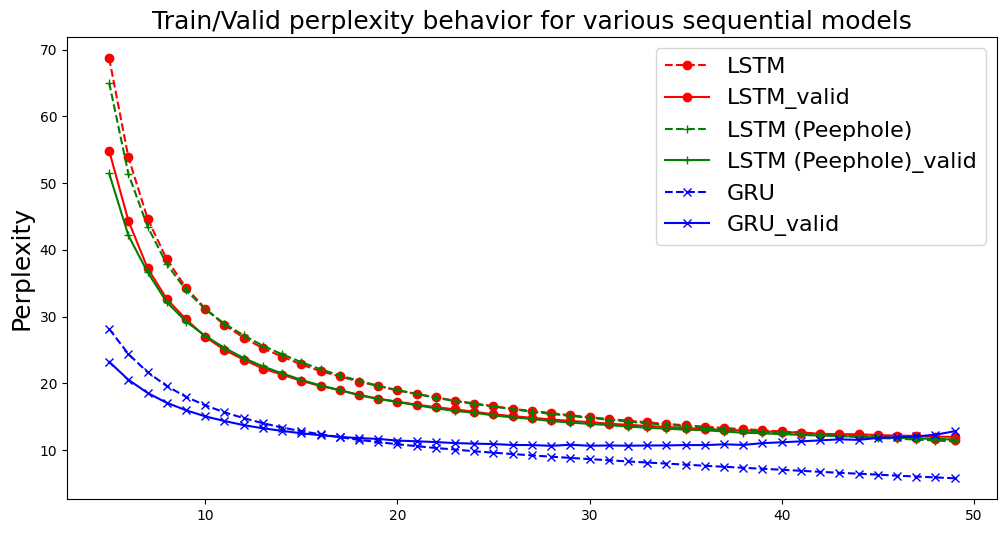

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

# Plots without the Word2vec related results
plt.figure(figsize=(12, 6)) 
k = 5

for model_name, history, marker, color in zip(
    ['LSTM', 'LSTM (Peephole)', 'GRU'], 
    [lstm_history, lstm_peephole_history, gru_history],
    ['o', '+', 'x'],
    ['red', 'green', 'blue']
):
    
    train_perplexity = history.history["perplexity"][k:]
    val_perplexity = history.history["val_perplexity"][k:]
    
    # Plot the training perplexities
    plt.plot(np.arange(k,len(train_perplexity)+k), 
               train_perplexity, marker=marker, markersize=6, linestyle='--' , color=color,
               label = model_name)
    
    plt.plot(np.arange(k, len(val_perplexity)+k), 
           val_perplexity, marker=marker, markersize=6, color=color,
           label = model_name+'_valid')

plt.legend(loc=1,fontsize=16)
plt.title('Train/Valid perplexity behavior for various sequential models',fontsize=18)
plt.ylabel('Perplexity',fontsize=18)


## LSTM with Beam-Search

Here we alter the previously defined prediction related TensorFlow operations to employ beam-search. Beam search is a way of predicting several time steps ahead. Concretely instead of predicting the best prediction we have at a given time step, we get predictions for several time steps and get the sequence of highest joint probability.

In [22]:
def beam_one_step(model, input_, states): 
    """ Perform the model update and output for one step"""
    out = model.predict([input_, *states])
    output, new_states = out[0], out[1:]
    return output, new_states


def beam_search(model, input_, states, beam_depth=5, beam_width=3):
    """ Defines an outer wrapper for the computational function of beam search """
    
    vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
    index_word = dict(zip(range(len(vocabulary)), vocabulary))

    def recursive_fn(input_, states, sequence, log_prob, i):
        """ This function performs actual recursive computation of the long string"""
        
        if i == beam_depth:
            """ Base case: Terminate the beam search """
            results.append((list(sequence), states, np.exp(log_prob)))            
            return sequence, log_prob, states
        else:
            """ Recursive case: Keep computing the output using the previous outputs"""
            output, new_states = beam_one_step(model, input_, states)
            
            # Get the top beam_widht candidates for the given depth
            top_probs, top_ids = tf.nn.top_k(output, k=beam_width)
            top_probs, top_ids = top_probs.numpy().ravel(), top_ids.numpy().ravel()
            
            # For each candidate compute the next prediction
            for p, wid in zip(top_probs, top_ids):                
                new_log_prob = log_prob + np.log(p)
                
                # we are going to penalize joint probability whenever the same symbol is repeating
                if len(sequence)>0 and wid == sequence[-1]:
                    new_log_prob = new_log_prob + np.log(1e-1)
                    
                sequence.append(wid)                
                _ = recursive_fn(np.array([[index_word[wid]]]), new_states, sequence, new_log_prob, i+1)                                         
                sequence.pop()
        
    
    results = []
    sequence = []
    log_prob = 0.0
    recursive_fn(input_, states, sequence, log_prob, 0)    

    results = sorted(results, key=lambda x: x[2], reverse=True)

    return results

In [23]:
text = ["When adam and eve were driven out of paradise, they were compelled to build a house for themselves on barren ground"]

vocabulary = infer_model.get_layer("text_vectorization").get_vocabulary()
index_word = dict(zip(range(len(vocabulary)), vocabulary))


seq = [text[0][i:i+2] for i in range(0, len(text[0]), 2)]

# build up model state using the given string
print(f"Making {len(seq)} predictions from input")


# Reset the state of the model initially
lm_model.reset_states()

# Definin the initial state as all zeros
state_c = np.zeros(shape=(1,512))
state_h = np.zeros(shape=(1,512))
state_c_1 = np.zeros(shape=(1,256))
state_h_1 = np.zeros(shape=(1,256))

states = [state_c, state_h, state_c_1, state_h_1]

# # Recursively update the model by assining new state to state
# for c in seq:    
#     out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
#         [np.array([[c]]), state_c, state_h, state_c_1, state_h_1]
# )

# # Get final prediction after feeding the input string
# wid = int(np.argmax(out[0],axis=-1).ravel())
# word = index_word[wid]
# text.append(word)

# # Define first input to generate text recursively from
# x = np.array([[word]])

# # Predict for 100 time steps
# for i in range(50):    
#     print('.', end='') 
    
#     # Get the results from beam search
#     result = beam_search(infer_model, x, states, 5, 5)
    
#     # Get one of the top 10 results based on their likelihood
#     n_probs = np.array([p for _,_,p in result[:10]])
#     p_j = np.random.choice(list(range(n_probs.size)), p=n_probs/n_probs.sum())                    
#     best_beam_ids, states, _ = result[p_j]
#     x = np.array([[index_word[best_beam_ids[-1]]]])
            
#     text.extend([index_word[w] for w in best_beam_ids])    

# print('\n')
# print('='*60)
# print("Final text: ")
# print(''.join(text))

Making 58 predictions from input


In [24]:
# Recursively update the model by assining new state to state
for c in seq:    
    out, state_c, state_h, state_c_1, state_h_1 = infer_model.predict(
        [np.array([[c]]), state_c, state_h, state_c_1, state_h_1]
)

# Get final prediction after feeding the input string
wid = int(np.argmax(out[0],axis=-1).ravel())
word = index_word[wid]
text.append(word)

# Define first input to generate text recursively from
x = np.array([[word]])

1/1 [==============================] - 0s 18ms/step


There is something within the beam_search method that runs forever ... and just keeps on printing the same line .. 

In [ ]:
# Predict for 100 time steps
for i in range(50):    
    print('.', end='') 
    
    # Get the results from beam search
    result = beam_search(infer_model, x, states, 5, 5)
    
    # Get one of the top 10 results based on their likelihood
    n_probs = np.array([p for _,_,p in result[:10]])
    p_j = np.random.choice(list(range(n_probs.size)), p=n_probs/n_probs.sum())                    
    best_beam_ids, states, _ = result[p_j]
    x = np.array([[index_word[best_beam_ids[-1]]]])
            
    text.extend([index_word[w] for w in best_beam_ids])    

# print('\n')
# print('='*60)
# print("Final text: ")
# print(''.join(text))

In [ ]:
print('\n')
print('='*60)
print("Final text: ")
print(''.join(text))

In [ ]:
endTime = time.time()
elapsedTime = time.strftime("%H:%M:%S", time.gmtime(endTime - startTime))

print(todaysDate.strftime('# Run Date: %A, %B %d, %Y'))
print(f"# Run Time: {elapsedTime}")